# Analyse des réacions Twitter à la sortie d'un film
### VIALARD DURAND NAZARENKO ENSAE 2019

L'objectif de ce projet est d'utiliser l'API de twitter pour analyser les critiques du film Avengers Endgame. Pour ce faire on va d'abord récolter des tweets sur le hashtag officiel #Endgame puis on effectuera différentes analyses des données récoltées.

On commence par indiquer à python dans quel dossier on va travailler.

In [1]:
import os

path="W:\Bureau"
os.chdir( path )
print(os.getcwd())

W:\Bureau


Pour utiliser ce code, nous pouvons vous fournir notre base de donnée pour que vous puissiez avoir un nombre suffisant de tweets ( le film étant sorti il y a plusieurs semaines, il provoque moins de réactions sur les réseaux sociax). Cependant, si vous souhaitez faire tourner l'algorithme de récolte, vous pouvez utiliser les 2 prochaines parties (quand vous voudrez finir la récolte, vous devrez arrêter manuellement l'algorithme).
Pour la suite, si vous déposez le fichier Endgame.json dans le bon dossier de travail, vous pouvez lancer chaque partie dans l'ordre.

Ensuite on se connecte à l'API twitter pour pouvoir accéder aux données

In [3]:
import tweepy
from tweepy import OAuthHandler
 
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''
 
maxTweets = 10000000   # Nombre de tweet max a recuperer
tw_block_size = 100    # Nombre de Tweet par requete
sinceId = None         # Recuperation des tweets du plus recent au plus ancien

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Il va ensuite falloir écrire un code pour récupérer les tweets en continu sur un hashtag paticulier, ici nous avons choisi le #Endgame qui est le hashtag officiel du film et qui permet donc d'être sûr que l'on va collecter des tweets variés.

In [ ]:
from tweepy import Stream
from tweepy.streaming import StreamListener
 
class MyListener(StreamListener):
 
    def on_data(self, data):
        try:
            with open('Endgame.json', 'a') as f:
                f.write(data)
                return True
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
 
    def on_error(self, status):
        print(status)
        return True
 
twitter_stream = Stream(auth, MyListener(), wait_on_rate_limit=True)
twitter_stream.filter(track=['#Endgame'])

S'en sont suivi quatre jours de récolte en continu de mercredi 24 avril matin (date de sortie du film) à dimanche 28 matin. Nous nous retrouvons donc avec un fichier au format .json contenant 5,2Go de tweets. Nous allons vérifier rapidement combien de tweets nous avons récupéré.

In [2]:
n_docs=0
json_file = open('Endgame.json', 'r')
for line in json_file:
    # On verifie si la ligne est vide
    if line.strip() == '':
        continue
    else:
        n_docs+=1
print (n_docs)

806208


On a donc récolté 806208 tweets. Cela semble suffisant pour avoir des résultats intéressants.

Nous allons commencer notre analyse en regardant quels mots sont les plus utilisés.

In [3]:
import json
from collections import Counter

json_file = open('Endgame.json', 'r')
count_all = Counter()
for line in json_file:
    # On verifie si la ligne est vide car on a remarqué que les tweets sont séparés d'une ligne vide ce qui faisait boguer le code
    if line.strip() == '':
        continue

    tweet = json.loads(line)
    terms_all = []
    if 'lang' not in tweet.keys():
        continue
    if tweet['lang'] in ['fr', 'en', 'es']: #On rajoute un tri sur la langue après avoir obtenu des résultats en Thaïlandais lors de l'analyse des co-occurences.
        if 'extended_tweet' in tweet:
            # Créé une liste avec tous les termes
            terms_all = [term for term in tweet['extended_tweet']['full_text'].split(' ')]
        elif 'text' in tweet:
            terms_all = [term for term in tweet['text'].split(' ')]
        else:
            continue
        # Met à jour le compteur
    count_all.update(terms_all)
# Affiche les 10 mots les plus utilisés
print(count_all.most_common(10))

[('RT', 425140), ('#Endgame', 322002), ('the', 269224), ('a', 144375), ('to', 132929), ('of', 126296), ('', 108431), ('I', 107497), ('and', 94594), ('#EndGame', 88400)]


Nous remarquons directement que l'analyse va être polluée par tous les mots de transitions qu'on appellera par la suite "stopwords" et par les différents hashtags. Nous allons donc créer une version adaptée de ce code qui permet d'éliminer ces mots inutiles. Après plusieurs tentatives, nous nous sommes rendus compte qu'il faut aussi enlever la ponctuation et les noms des utilisateurs commençant par @.

Avant de passer à la suite nous allons calculer la compléxité de cet algorithme. On appelle N le nombre de tweets dans la base de données. Nous majorons le nombre de mots dans un tweet par le nombre de caractères possible (280). Chaque tweet étant séparé d'une ligne vide, on a une base de 2N lignes. On effectue 2N lectures et dans N cas on effectue une lecture pour la langue puis dans le pire des cas la commande .split effectue 280 lectures et 140 écritures. La commande .update effectue ainsi 90 lectures et une écriture dans le pire des cas. La complexité totale est donc de N*1+N*(1+280+140+91)=O(N)

In [4]:
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')

json_file = open('Endgame.json', 'r')
count_stop = Counter()
punctuation = list(string.punctuation)
stop = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish') + punctuation + ['rt', 'via','RT',' ','...']
for line in json_file:
    # On verifie si la ligne est vide
    if line.strip() == '':
        continue
    terms_stop = []
    tweet = json.loads(line)
    if 'lang' not in tweet.keys(): #Une langue est elle renseignée par Twitter
        continue
    if tweet['lang'] in ['fr', 'en', 'es']: #On rajoute un tri sur la langue après avoir obtenu des résultats en Thaïlandais lors de l'analyse des co-occurences.
        if 'extended_tweet' in tweet:
            # Créé une liste avec tous les termes sauf les stop words
            terms_stop = [term for term in tweet['extended_tweet']['full_text'].split(' ') if term not in stop and not term.startswith(('#', '@'))] 
        elif 'text' in tweet:
            terms_stop = [term for term in tweet['text'].split(' ') if term not in stop and not term.startswith(('#', '@'))]
        else:
            continue
        # Met à jour le compteur
    count_stop.update(terms_stop)
#Affiche les 10 mots les plus utilisés
print(count_stop.most_common(10))

[nltk_data] Downloading package stopwords to W:\AppData\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[('', 108431), ('I', 107497), ('Happy', 49987), ('Day!!', 48241), ('https://t.co/CFipXu5uUj', 48164), ("It's", 39216), ('day', 39147), ('someone', 35660), ('waiting', 34711), ('Did', 33702)]


On commence déjà à avoir des résultats intéressants malgré quelques parasites comme 'I' ou 'It's' on retrouve notamment en 3eme position le mot 'Happy', les tweetos on donc plutôt apprécié le film ou étaient contents de sa sortie puisqu'on retrouve aussi les mots 'day' et 'waiting'. Pour avoir une idée un peu plus précise de ce qui est dit on pense alors à compter les couples de mots pour essayer de former des bouts de phrase donnant plus de sens à certains mots.

In [5]:
from nltk import bigrams

json_file = open('Endgame.json', 'r')
count_all = Counter()
punctuation = list(string.punctuation)
stop = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish') + punctuation + ['rt', 'via','RT',' ','...']
for line in json_file:
    # On verifie si la ligne est vide
    if line.strip() == '':
        continue

    tweet = json.loads(line)
    terms_bigram = []
    if 'lang' not in tweet.keys():
        continue
    if tweet['lang'] in ['fr', 'en', 'es']: #On rajoute un tri sur la langue après avoir obtenu des résultats en Thaïlandais lors de l'analyse des co-occurences.
        if 'extended_tweet' in tweet:
            # Créé une liste avec tous les termes sauf les stopwords
            terms_stop = [term for term in tweet['extended_tweet']['full_text'].split(' ') if term not in stop and not term.startswith(('#', '@'))]
            terms_bigram = bigrams(terms_stop)
        elif 'text' in tweet:
            terms_stop = [term for term in tweet['text'].split(' ') if term not in stop and not term.startswith(('#', '@'))]
            terms_bigram = bigrams(terms_stop)
        else:
            continue
        # Mise à jour du compteur
    count_all.update(terms_bigram)
#On affiche les 10 couples de mots les plus cités
print(count_all.most_common(10))

[(('', ''), 70575), (('Happy', 'Day!!'), 48225), (('Day!!', 'https://t.co/CFipXu5uUj'), 48164), (('Did', 'someone'), 33110), (('someone', 'say...'), 33089), (('say...', 'Tomorrow?'), 33075), (('Tomorrow?', 'https://t.co/RQrNKj5Hyv'), 33069), (("we've", 'waiting'), 32833), (('ride', 'lifetime.'), 32828), (("Today's", 'day'), 32827)]


On comprend alors que grand nombre de tweets, même si ils ont tous été postés après la sortie du film, parlent de l'attente et de l'impatience de le voir. On a aussi essayé en rajoutant les @-pseudos et les hashtags pour voir si on pouvait en déduire autre chose mais ce n'était pas concluant. On va donc désormais s'intéresser aux co-occurences des mots cette fois-ci en laissant les @-pseudos au cas où.

In [7]:
from collections import defaultdict
import operator

 
com = defaultdict(lambda : defaultdict(int))
json_file = open('Endgame.json', 'r')
punctuation = list(string.punctuation)
stop = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish') + punctuation + ['rt', 'via','RT',' ','...']
for line in json_file: 
    # On verifie si la ligne est vide
    if line.strip() == '':
        continue

    tweet = json.loads(line)
    if 'lang' not in tweet.keys():
        continue
    if tweet['lang'] in ['fr', 'en', 'es']: #On rajoute un tri sur la langue après avoir obtenu des résultats en Thaïlandais lors de l'analyse des co-occurences.
        if 'extended_tweet' in tweet:
            #Création d'une liste avec tous les termes sauf les stopwords
            terms_stop = [term for term in tweet['extended_tweet']['full_text'].split(' ') if term not in stop and not term.startswith(('#'))]
        elif 'text' in tweet:
            terms_stop = [term for term in tweet['text'].split(' ') if term not in stop and not term.startswith(('#'))]
        else:
            continue
            # Met à jour le compteur
    count_stop.update(terms_stop)
    for i in range(len(terms_stop)-1):            
        for j in range(i+1, len(terms_stop)):
            w1, w2 = sorted([terms_stop[i], terms_stop[j]])                
            if w1 != w2:
                com[w1][w2] += 1
com_max = []
# Pour chaque terme on regarde quels sont les autres termes qui ont le plus d'occurences
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Renvoie les co-occurences les plus fréquentes
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:5])

[(('', '•_•)'), 55215), (('', '(•_•'), 55215), (('', 'ง'), 55215), (('', ')ง'), 55215), (('', '୧('), 55215)]


Nous obtenions alors des symboles très étranges qui seraient (d'après nos recherche sur internet) du Thaïlandais ce qui polluait les co-occurences les plus fréquentes mais qui n'empêchait pas la table com d'être valide. Même si nous n'avons pas pour but d'étudier la portée géographique du film, on aurait pu en déduire à première vue que le public Thaïlandais etait très présent sur Twitter. Cependant nous avons tout de même choisi de rajouter sur les précédentes parties un filtre sur les lanques des tweets. Il s'avère en fait que les symboles étranges sont des émojis on a donc choisi de les laisser. 
C'est dans cette partie que nous avons rencontré notre principale difficulté. En effet, nous ne trouvions pas comment calculer les co-occurences maximales de chaque mot. Le problème était notamment le nombre de langue trop grand de notre base de données. Nous avons alors décidé d'utiliser le package python defaultdict qui permet de créer des dictionnaires différents facilment. Ce qui nous a permi d'étudier facilment les co-occurences de chaque mot après un tri sur la langue du Tweet.
Pour l'instant nous allons appeler certains mots et voir quels sont leurs co-occurences maximales.

In [18]:
sorted(com['happy'].items(), key=operator.itemgetter(1), reverse=True)[:5]

[('sad', 211), ('see', 177), ('movie', 138), ('seeing', 97), ('like', 91)]

In [19]:
sorted(com['cool'].items(), key=operator.itemgetter(1), reverse=True)[:5]

[('see', 94), ('really', 88), ('movie', 83), ('people', 71), ('super', 69)]

In [20]:
sorted(com['bad'].items(), key=operator.itemgetter(1), reverse=True)[:5]

[('us', 141), ('fans', 137), ('news.', 128), ('wiped', 128), ('thin…', 127)]

In [21]:
sorted(com['boring'].items(), key=operator.itemgetter(1), reverse=True)[:5]

[('one', 11), ('movie', 10), ('marvel', 7), ('time', 7), ('movie.', 7)]

In [22]:
sorted(com['spoilers'].items(), key=operator.itemgetter(1), reverse=True)[:5]

[('without', 10984),
 ('tweet', 1411),
 ('vibra', 1174),
 ('✨💫Este', 1173),
 ('trying', 613)]

Après quelques requêtes, les twittos semblent avoir plutôt apprécié le film malgré quelques rares exceptions.

On va finalement réaliser une ananlyse sémantique des sentiments. On commence par initialiser une table avec tous les mots et deux listes de mots positifs et négatifs en anglais français et espagnol (langues que nous comprenons). Cette contribution, permet d'avoir un avis plus global (mais toujours compréhensible pour nous) et de ne pas nous limiter à des résultats uniquement français ou anglais.

In [8]:
import math

#On commence par compter le nombre n_docs de tweets dans le document.
n_docs=0
json_file = open('Endgame.json', 'r')
for line in json_file:
    # On verifie si la ligne est vide
    if line.strip() == '':
        continue
    else:
        n_docs+=1
        
p_t = {}
p_t_com = defaultdict(lambda : defaultdict(int))
 
for term, n in count_stop.items():
    p_t[term] = n / n_docs
    for t2 in com[term]:
        p_t_com[term][t2] = com[term][t2] / n_docs
        
#       
positive_vocab = [
    'amazing', 'brilliant', 'cool', 'delightful', 'good', 'excellent', 'exciting', 'nice', 'great', 'awesome', 'outstanding',
    'fantastic', 'fabulous', 'legendary', 'marvelous', 'perfect', 'remarkable', 'terrific', ':)', ':-)', 'like', 'love',
    'génial', 'bien', 'aime', 'adore', 'merveilleux', 'remarcable','bon','maravilloso','buen','bueno'

]
negative_vocab = [
    'awful', 'boring','stupid', 'deplorable','horrible','sad','unhappy','unfair','upset', 'bad', 'terrible', 'crap', 'useless', 'hate', ':(', ':-(',
    'nul', 'stupide', 'ennuyant', 'triste', 'bête', 'colère', 'énervé', 'mauvais','naze','pourri', 'nulo', 'aburrido', 'estúpido', 'malo'
]

Maintenant on associe à chaque terme son orientation sémantique puis on affiche les 10 meilleurs et les 10 pires

In [9]:
#
pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in com[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log2(p_t_com[t1][t2] / denom)
        
#
semantic_orientation = {}
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc

semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
 
print(top_pos)
print(top_neg)

[('3000.\n#ThankYouAvengers', 26.107106884170616), ('@melissadimarco’s', 24.686265342918077), ('@ImagineMarketSq', 24.686265342918077), ('LOOOOOOOOVE', 24.535963544905336), ('\n\nhttps://t.co/QaIuctvxwn', 24.535963544905336), ('Qu’on', 23.965460741838108), ('action,', 22.926063865994895), ('@pantaloonsindia', 22.542483478970254), ('(Also,', 22.159223510742407), ("C'était", 21.874077968875998)]
[('Day', -35.4627846566014), ('Spoilers', -35.57722852197498), ("We're", -35.78208697880447), ('Man', -36.01948728796323), ('7', -36.028287868065696), ('Me', -37.08706652289055), ('', -37.916252426253465), ('Spoiler', -38.51250146303767), ('Yo', -45.08094236061589), ('Happy', -78.35582407651928)]


L’analyse sémantique révèle que c’est bien les scènes d’action du film qui ont été les plus appréciées. De plus, le personnage interprété par Jeremy Renner a un role tout particulier et a été très apprécié par les fan. Le hashtag #ThankYouAvengers a été plebiscité et montre que ces héros ont été très appréciés. Le chiffre 3000 qui le précède est une référence au film symbolisant l’amour. Mellissa di marco est une journaliste américaine, https://t.co/QaIuctvxwnun est un lien vers la dernière interview des frères Russo (les réalisateurs) avant la sortie et enfin l'apparition du mot LOOOOOOOOVE nous conforte dans l'idée que l'analyse sémantique a été bien réalisée. Tout ces éléments semblent indiquer un bon retour des fans et de la critique sur le dernier film de la frnachise lancée il y a une décennie.

Le terme Spoiler (et Spoilers) est lui forcément mal orienté sémantiquement.

On regarde l'orientation sémantique de certains mots

In [10]:
print("Iron Man: %f" % semantic_orientation['Iron'])
print("Thor: %f" % semantic_orientation['Thor'])
print("Captain America: %f" % semantic_orientation['America'])
print("Hulk: %f" % semantic_orientation['Hulk'])
print("Hawkeye: %f" % semantic_orientation['Hawkeye'])
print("Widow: %f" % semantic_orientation['Widow'])
print("Thanos: %f" % semantic_orientation['Thanos'])

Iron Man: -30.970102
Thor: -32.632135
Captain America: -24.881697
Hulk: -27.673754
Hawkeye: -11.521689
Widow: -8.954122
Thanos: -27.943822


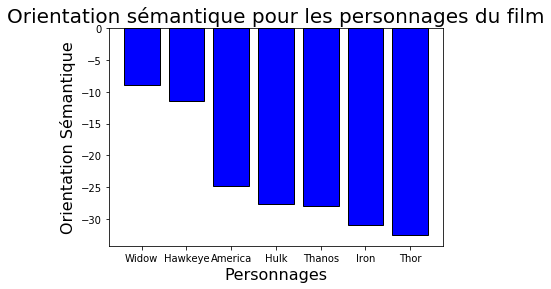

In [15]:
sem = [semantic_orientation['Widow'],semantic_orientation['Hawkeye'],semantic_orientation['America'],semantic_orientation['Hulk'],semantic_orientation['Thanos'],semantic_orientation['Iron'],semantic_orientation['Thor']]

import matplotlib.pyplot as plt

import numpy as np
perso=['Widow','Hawkeye','America','Hulk','Thanos','Iron','Thor']
pos = np.arange(len(perso))
plt.bar(perso,sem,color='blue',edgecolor='black')
plt.xticks(pos, perso)
plt.xlabel('Personnages', fontsize=16)
plt.ylabel('Orientation Sémantique', fontsize=16)
plt.title('Orientation sémantique pour les personnages du film',fontsize=20)
plt.show()

Après une analyse des noms des principaux personnages, nous observons certaines limites de notre programme. En effet, le méchant Thanos est forcément mal orienté mais les héros Thor et Iron Man le sont encore plus. Pour Thor, le nouveau traitement de son personnage n'a pas étét très apprécié par les fans. Cependant pour Iron Man, notre programme ne fait pas la différence entre la tristesse provoquée par le film (qui n'est pas forcément négative) et des opinions négatives sur le film. En effet, nous avons défini le terme 'sad' comme négatif.

Notre algorithme (sur une base de données assez importante) permet d'avoir un retour rapide sur les réactions des spectateurs à un film. Une de ses limites reste la complexité du texte. En effet, lors de la tokenisation des Tweets l'expression "It's not good" par exemple sera séparé en "it's", "not" et "good" et lors des cooccurences, c'est le mot good (qui est orienté positivement) qui sera associé alors que l'avis initial n'est pas forcément bon.